<a href="https://colab.research.google.com/github/RajathKashyap/Online-Shoppers-Purchasing-Intention/blob/RajathKashyap-patch/Online_shopper_purchasing_intention_(optimized).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install shap pdpbox imblearn -q

     |████████████████████████████████| 235kB 1.4MB/s 
     |████████████████████████████████| 57.7MB 466kB/s 


In [2]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
import shap
import plotly.graph_objs as go
import warnings

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score

from imblearn.over_sampling import SMOTE

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).



In [3]:
warnings.filterwarnings('ignore')

# Load the data into a dataframe. The data is downloaded from the below url and the downloaded csv is loaded.
URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00468/online_shoppers_intention.csv"
data=pd.read_csv(URL)
data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [4]:
# The statistics of the loaded data
data.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157213,0.016813,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


In [5]:
# Check for null values
data.isnull().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

In [6]:
# The revenue and weekend attributes which are string types are converted to integer values
data['Revenue'] = data['Revenue'].astype(int)
data['Weekend'] = data['Weekend'].astype(int)
data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,0,0
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,0,0
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,0,0
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,0,0
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,1,0


Text(0, 0.5, 'Total Revenue')

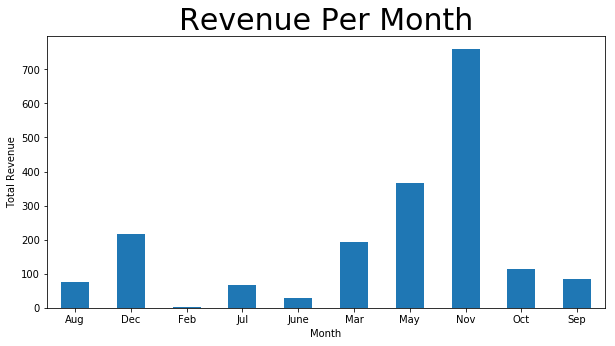

In [7]:
# Total Revenue by month.

monthly_revenue = data.groupby(['Month'])[['Revenue']].agg('sum')
graph = monthly_revenue.unstack().plot(kind='bar', figsize=(10,5))
plt.xticks(np.arange(10), sorted(data.Month.unique()), rotation=0)
graph.set_xlabel('Month')
plt.title('Revenue Per Month', fontsize = 30)
graph.set_ylabel('Total Revenue')
# plt.show()
# plt.savefig("monthly_revenue")

Highest Revenue is in the month of November

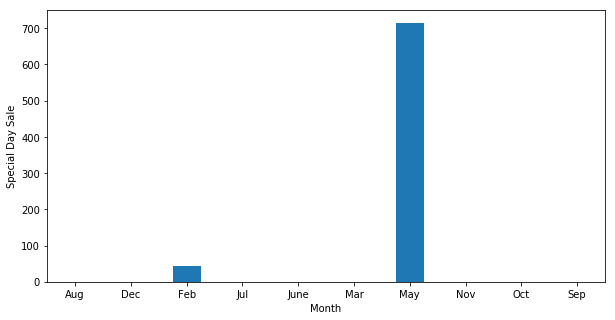

In [8]:
# The distribution of special days
specialDay_data = data.groupby(['Month'])[['SpecialDay']].agg('sum')
graph = specialDay_data.unstack().plot(kind='bar', figsize=(10,5))
plt.xticks(np.arange(10), sorted(data.Month.unique()), rotation=0)
graph.set_xlabel('Month')
graph.set_ylabel('Special Day Sale')
plt.show()


The special day feature is only present in the months of February and May, which is a bit surprising

27009.85943
0.0
(-0.001, 1.0]          13
(1.0, 2.0]              0
(2.0, 4.0]              0
(4.0, 10.0]             6
(10.0, 23.0]           13
(23.0, 50.0]           17
(50.0, 110.0]          40
(110.0, 243.0]         89
(243.0, 532.0]        285
(532.0, 1167.0]       530
(1167.0, 2558.0]      503
(2558.0, 5608.0]      295
(5608.0, 12291.0]     101
(12291.0, 26940.0]     15
(26940.0, 59049.0]      1
Name: ProductRelated_Duration, dtype: int64


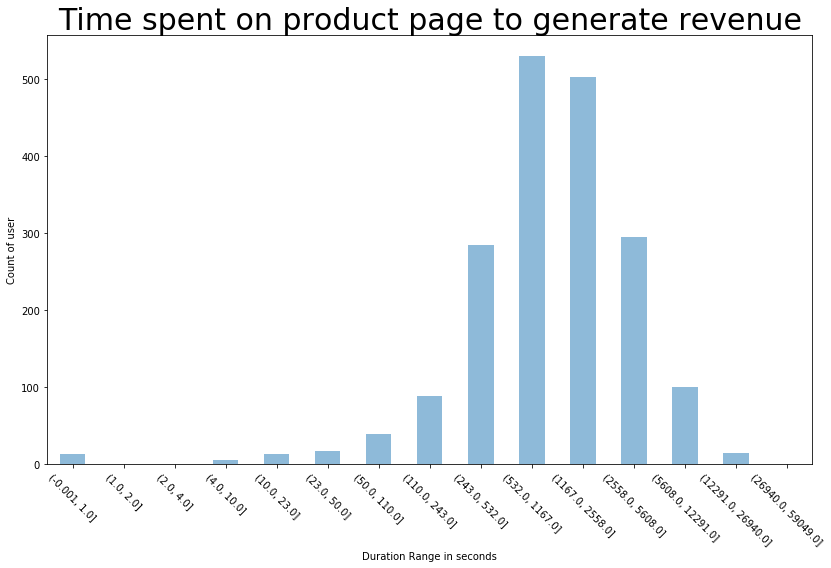

In [9]:
# Users buy a product or not based on how much time he spends on a product page.
product_bought = data[data['Revenue'] == True]
print(product_bought['ProductRelated_Duration'].max())
print(product_bought['ProductRelated_Duration'].min())

log_spaced_data = np.logspace(start=0,stop=10,num=15,base=3,dtype='int',
                              endpoint=True)
log_spaced_data = np.append([0],log_spaced_data)
d = pd.cut(product_bought['ProductRelated_Duration'],
           log_spaced_data, right=True,include_lowest=True)
print(d.value_counts(sort=False))
a = d.value_counts(sort=False).plot.bar(rot=-45,alpha=0.5,
                                         figsize=(12,8))
a.set_ylabel('Count of user')
a.set_xlabel('Duration Range in seconds')
plt.title('Time spent on product page to generate revenue', fontsize = 30)
plt.tight_layout()
# plt.savefig("ProductDurationBasedRevenue.png")

1767.6666670000002
0.0
(0, 1]              0
(1, 2]              4
(2, 4]              6
(4, 10]            41
(10, 23]           54
(23, 50]          100
(50, 110]         107
(110, 243]        113
(243, 532]         87
(532, 1167]        45
(1167, 2558]        8
(2558, 5608]        0
(5608, 12291]       0
(12291, 26940]      0
(26940, 59049]      0
Name: Informational_Duration, dtype: int64


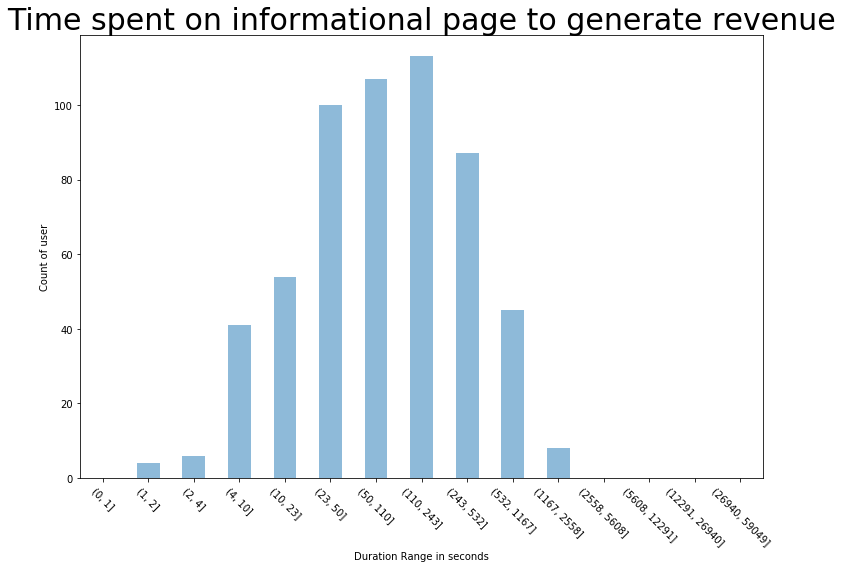

In [10]:
product_bought = data[data['Revenue'] == True]
print(product_bought['Informational_Duration'].max())
print(product_bought['Informational_Duration'].min())


log_spaced_data = np.logspace(start=0,stop=10,num=15,base=3,dtype='int',
                              endpoint=True)
log_spaced_data = np.append([0],log_spaced_data)
d = pd.cut(product_bought['Informational_Duration'],
           log_spaced_data, right=True,include_lowest=False)
print(d.value_counts(sort=False))
a = d.value_counts(sort=False).plot.bar(rot=-45,alpha=0.5,
                                         figsize=(12,8))
a.set_ylabel('Count of user')
a.set_xlabel('Duration Range in seconds')
plt.title('Time spent on informational page to generate revenue', fontsize = 30)
plt.tight_layout()
plt.savefig("InfoDurationBasedRevenue.png")

2086.75
0.0
(0, 1]              0
(1, 2]              2
(2, 4]             15
(4, 10]            45
(10, 23]           97
(23, 50]          233
(50, 110]         364
(110, 243]        329
(243, 532]        198
(532, 1167]        63
(1167, 2558]       14
(2558, 5608]        0
(5608, 12291]       0
(12291, 26940]      0
(26940, 59049]      0
Name: Administrative_Duration, dtype: int64


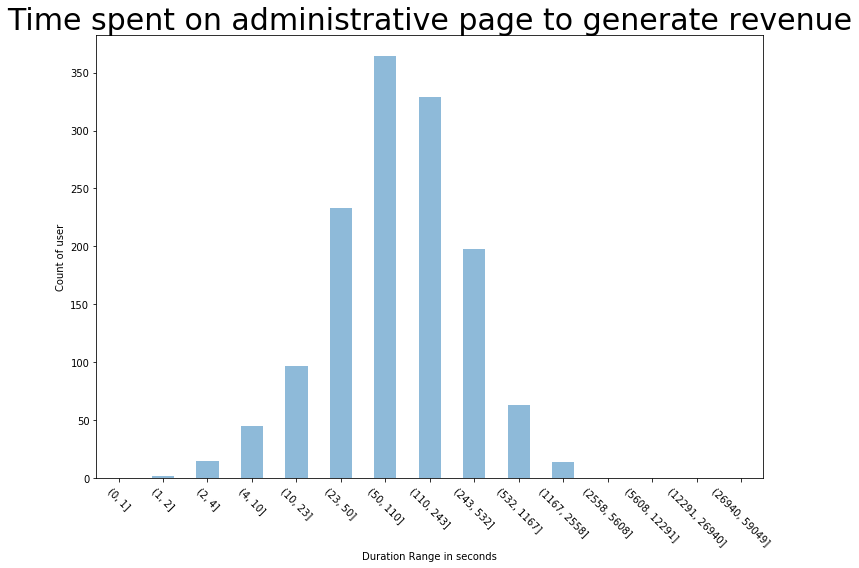

In [11]:
product_bought = data[data['Revenue'] == True]
print(product_bought['Administrative_Duration'].max())
print(product_bought['Administrative_Duration'].min())


log_spaced_data = np.logspace(start=0,stop=10,num=15,base=3,dtype='int',
                              endpoint=True)
log_spaced_data = np.append([0],log_spaced_data)
d = pd.cut(product_bought['Administrative_Duration'],
           log_spaced_data, right=True,include_lowest=False)
print(d.value_counts(sort=False))
a = d.value_counts(sort=False).plot.bar(rot=-45,alpha=0.5,
                                         figsize=(12,8))
a.set_ylabel('Count of user')
a.set_xlabel('Duration Range in seconds')
plt.title('Time spent on administrative page to generate revenue', fontsize = 30)
plt.tight_layout()
plt.savefig("AdminDurationBasedRevenue.png")

2086.75
0.0
(0, 1]              0
(1, 2]              2
(2, 4]             15
(4, 10]            45
(10, 23]           97
(23, 50]          233
(50, 110]         364
(110, 243]        329
(243, 532]        198
(532, 1167]        63
(1167, 2558]       14
(2558, 5608]        0
(5608, 12291]       0
(12291, 26940]      0
(26940, 59049]      0
Name: Administrative_Duration, dtype: int64


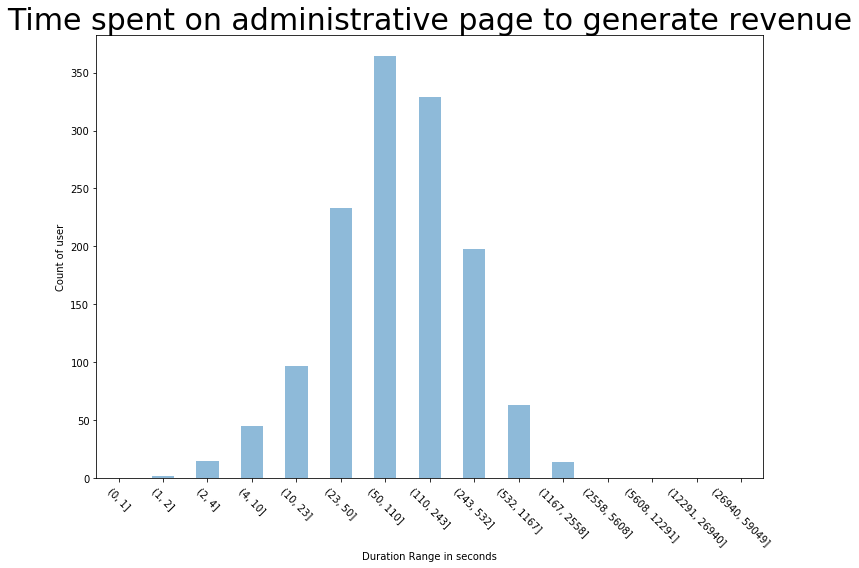

In [12]:
product_bought = data[data['Revenue'] == True]
print(product_bought['Administrative_Duration'].max())
print(product_bought['Administrative_Duration'].min())


log_spaced_data = np.logspace(start=0,stop=10,num=15,base=3,dtype='int',
                              endpoint=True)
log_spaced_data = np.append([0],log_spaced_data)
d = pd.cut(product_bought['Administrative_Duration'],
           log_spaced_data, right=True,include_lowest=False)
print(d.value_counts(sort=False))
a = d.value_counts(sort=False).plot.bar(rot=-45,alpha=0.5,
                                         figsize=(12,8))
a.set_ylabel('Count of user')
a.set_xlabel('Duration Range in seconds')
plt.title('Time spent on administrative page to generate revenue', fontsize = 30)
plt.tight_layout()
plt.savefig("AdminDurationBasedRevenue.png")

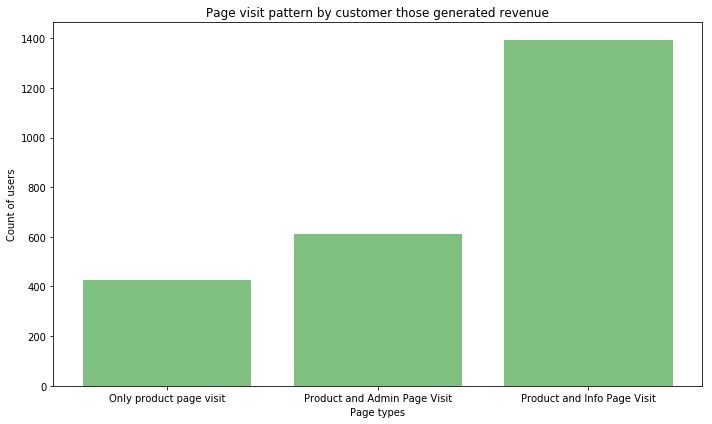

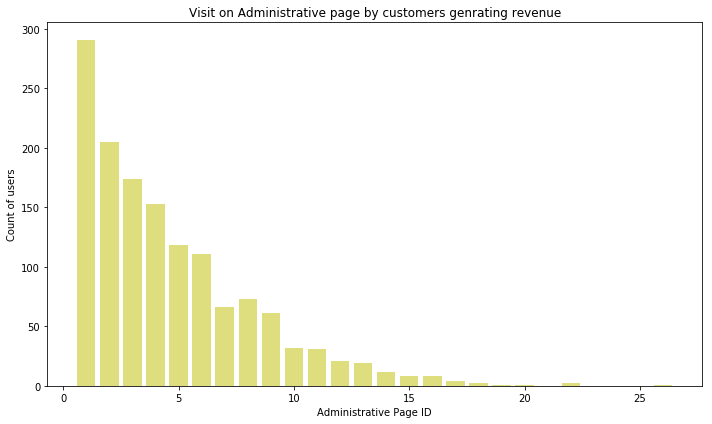

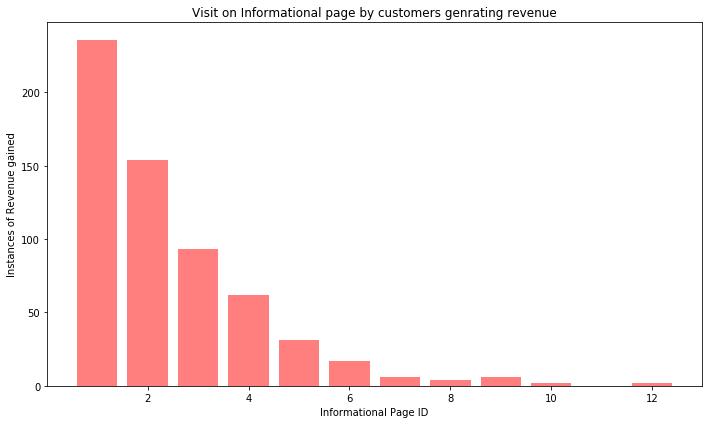

In [13]:
# User’s buying intention based on how he/she visits on other pages of the 
# website (i.e Informative and Administrative).

product_bought_with_no_other_page = data[(data['Informational'] == 0) &
                      (data['Administrative'] == 0) &
                      (data['Revenue']==True)]

product_bought_info = data[(data['Informational'] != 0) & 
                       (data['Revenue']==True)]
                      
product_bought_admin = data[(data['Administrative'] != 0) &
                      (data['Revenue']==True)]

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
# ax1 = fig.add_subplot(312)
# ax2 = fig.add_subplot(313)


#Products Revenue on visiting at admin page or info page in comparision to not 
# visiting them.
pb_distri = ax.bar(["Only product page visit","Product and Admin Page Visit", "Product and Info Page Visit"],
                  [len(product_bought_with_no_other_page.index),
                  len(product_bought_info.index),
                  len(product_bought_admin.index)],alpha=0.5,color='g')
ax.set(xlabel="Page types", 
        ylabel="Count of users",
        title="Page visit pattern by customer those generated revenue")
fig.tight_layout()
fig.savefig('user_page_visits')

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

#Product bought when visit on a Administrative page
gp_admin = product_bought_admin[["Administrative",'Revenue']].groupby(
    "Administrative",as_index = False).count()
ax.bar(gp_admin["Administrative"],gp_admin["Revenue"],alpha=0.5,color='y')
ax.set(xlabel="Administrative Page ID", 
        ylabel="Count of users",
        title="Visit on Administrative page by customers genrating revenue")
fig.tight_layout()
fig.savefig('admin_page_visits')

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
#Product bought when visit on a Informational page
gp_info = product_bought_info[["Informational",'Revenue']].groupby(
    "Informational",as_index = False).count()
ax.bar(gp_info["Informational"],gp_info["Revenue"],alpha=0.5,color='r')
ax.set(xlabel="Informational Page ID", 
        ylabel="Instances of Revenue gained",
        title="Visit on Informational page by customers genrating revenue")
fig.tight_layout()
fig.savefig('info_page_visits')

Revenue    77
dtype: int64
Revenue    1174
dtype: int64
       count
Month       
Feb        2
May       75


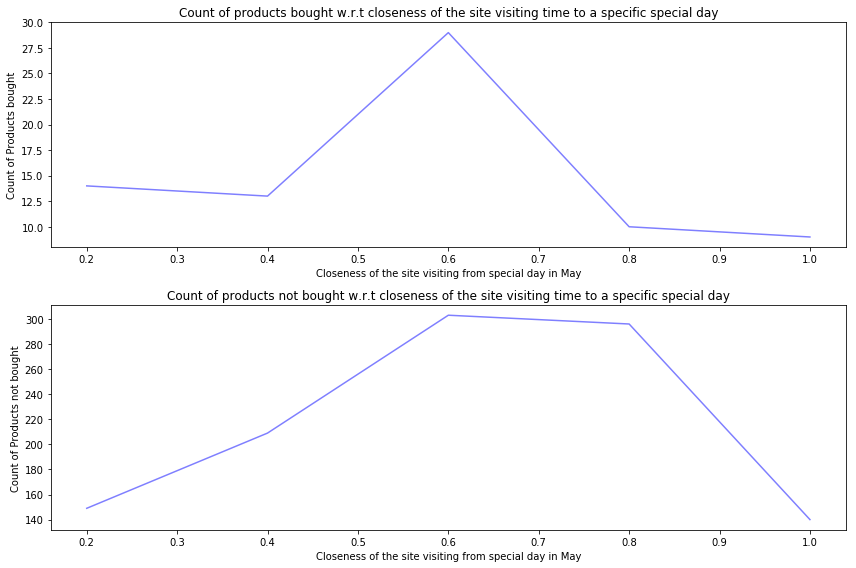

In [14]:
#User product buying patterns on special day (e.g Mother’s Day, Valentine's Day).
product_bought = data[(data['Revenue'] == True) & (data['SpecialDay'] > 0)]
product_not_bought = data[(data['Revenue'] == False) & (data['SpecialDay'] > 0)]

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
print(product_bought[['Revenue']].count())
print(product_not_bought[['Revenue']].count())

# Product bought on special days.
print(product_bought.groupby(['Month'],as_index = False)['SpecialDay'].agg(
    ["count"]))

# We can see that we have data for only two months, 
# we will explore more for buying patterns for special days in May.
product_bought= product_bought[product_bought['Month'] == 'May'][['Month','SpecialDay']]
gb = product_bought.groupby('SpecialDay',as_index = False).count()
ax1.plot(gb['SpecialDay'], gb['Month'],alpha=0.5,color="b")
ax1.set(title='Count of products bought w.r.t closeness of the site visiting'
       + ' time to a specific special day',xlabel = 'Closeness of the site visiting from special day in May',
      ylabel = 'Count of Products bought')


product_not_bought= product_not_bought[product_not_bought['Month'] == 'May'][['Month','SpecialDay']]
gb = product_not_bought.groupby('SpecialDay',as_index = False).count()
ax2.plot(gb['SpecialDay'], gb['Month'],alpha=0.5,color="b")
ax2.set(title='Count of products not bought w.r.t closeness of the site visiting'
       + ' time to a specific special day',xlabel = 'Closeness of the site visiting from special day in May',
      ylabel = 'Count of Products not bought')

fig.tight_layout()
fig.show()

May     3364
Nov     2998
Mar     1907
Dec     1727
Oct      549
Sep      448
Aug      433
Jul      432
June     288
Feb      184
Name: Month, dtype: int64


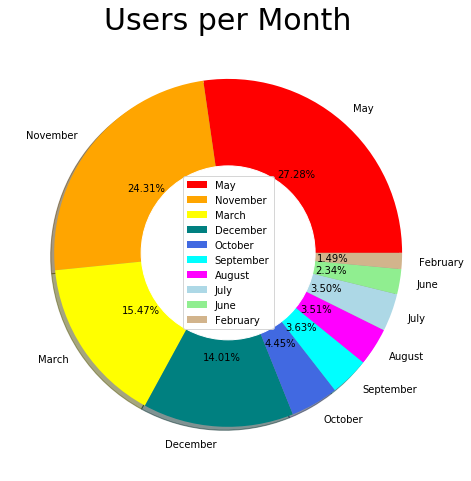

In [15]:
#checking the months with most no.of customers visiting the online shopping sites
print(data['Month'].value_counts())

# plotting a pie chart for share of customers per month
plt.rcParams['figure.figsize'] = (20, 8)
size = [3364, 2998, 1907, 1727, 549, 448, 433, 432, 288, 184]
colors = ['red', 'orange', 'yellow', 'teal', 'royalblue', 'cyan', 'magenta', 'lightblue', 'lightgreen', 'tan']
labels = "May", "November", "March", "December", "October", "September", "August", "July", "June", "February"
explode = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

circle = plt.Circle((0, 0), 0.5, color = 'white')

plt.subplot(1, 2, 2)
plt.pie(size, colors = colors, labels = labels,  explode=explode, shadow = True, autopct = '%.2f%%')
plt.title('Users per Month', fontsize = 30)
p = plt.gcf()
p.gca().add_artist(circle)
plt.legend(loc='center')
plt.savefig('user-visit.png',alpha=0.3)

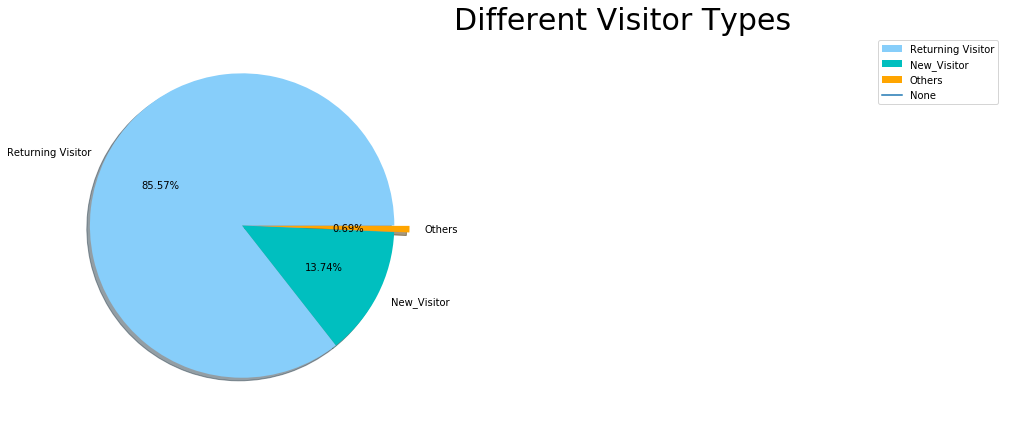

In [16]:
# plotting a pie chart for different Visitors

plt.rcParams['figure.figsize'] = (18, 7)
visitor = data
size = visitor['VisitorType'].value_counts()
colors = ['lightskyblue', 'c', 'orange']
labels = "Returning Visitor", "New_Visitor", "Others"
explode = [0, 0, 0.1]
plt.subplot(1, 1, 1)
plt.pie(size, colors = colors, labels = labels, explode = explode, shadow = True, autopct = '%.2f%%')
plt.title('Different Visitor Types', fontsize = 30)
plt.axis('off')
plt.legend()

# checking the Distribution of customers on Weekend
visitor = visitor.loc[:,['VisitorType','Revenue']]
# plt.subplot(1, 2, 2)
visitor.groupby(['VisitorType','Revenue']).agg(np.size).plot(legend=True)
# sns.countplot(data['Weekend'], palette = 'inferno')
# plt.title('Purchase on Weekends', fontsize = 30)
# plt.xlabel('Weekend or not', fontsize = 15)
# plt.ylabel('count', fontsize = 15)

plt.savefig('visitor_types.png')

VisitorType        Revenue
New_Visitor        0           2544
                   1            844
Other              0            138
                   1             32
Returning_Visitor  0          18162
                   1           2940
dtype: int64


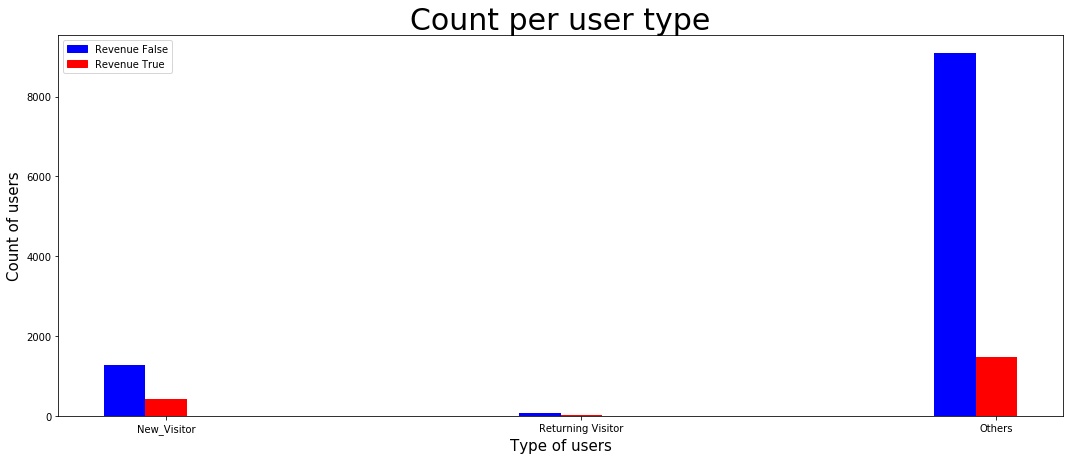

In [17]:
import matplotlib.patches as mpatches
visitor = data
visitor = visitor.loc[:,['VisitorType','Revenue']]
# plt.subplot(1, 2, 2)
visitor = visitor.groupby(['VisitorType','Revenue']).agg(np.size)

print(visitor)
fig = plt.figure()
ax = fig.add_subplot(111)

# ax.bar(0,[visitor.iloc[0]],color='r')

for a in range(0,6,2):
    ax.bar((a/2)-0.1,visitor.iloc[a]/2,color='b',width=0.1,align='center')
    ax.bar(a/2,visitor.iloc[a+1]/2,color='r',width=0.1,align='center')

legend_dict = { 'Revenue False' : 'blue', 'Revenue True' : 'red'}
patchList = []
for key in legend_dict:
        data_key = mpatches.Patch(color=legend_dict[key], label=key)
        patchList.append(data_key)
plt.legend(handles=patchList)
plt.title('Count per user type', fontsize = 30)
plt.xlabel('Type of users', fontsize = 15)
plt.ylabel('Count of users', fontsize = 15)
plt.xticks([0, 1, 2], ["New_Visitor","Returning Visitor", "Others"])
# ax.autoscale(tight=True)
plt.savefig('visitor_type_count.png')

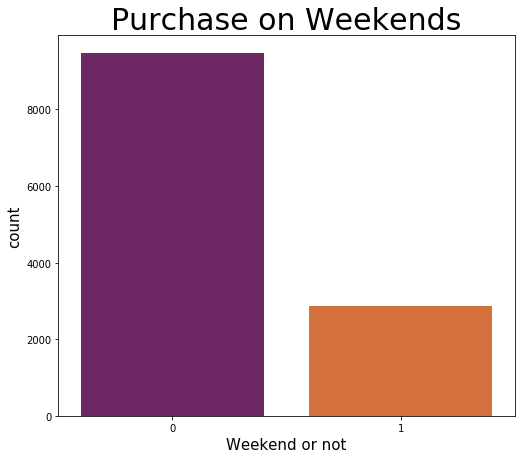

In [18]:
plt.subplot(1, 2, 2)
sns.countplot(data['Weekend'], palette = 'inferno')
plt.title('Purchase on Weekends', fontsize = 30)
plt.xlabel('Weekend or not', fontsize = 15)
plt.ylabel('count', fontsize = 15)
plt.savefig('weekend_purchase')

The count of users on weekdays is significantly greater than on weekends. This may mean that people prefer to shop online when they do not have the time to go out during weekdays and go out during weekends.

In [19]:
visitor = data
visitor = visitor.loc[:,['VisitorType','Revenue']]
# plt.subplot(1, 2, 2)
visitor.groupby(['VisitorType','Revenue']).agg(np.size)


VisitorType        Revenue
New_Visitor        0           2544
                   1            844
Other              0            138
                   1             32
Returning_Visitor  0          18162
                   1           2940
dtype: int64

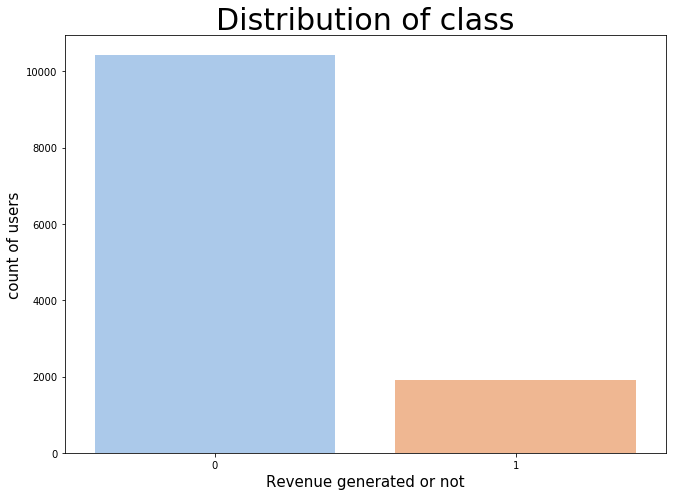

In [20]:
# checking the Distribution of customers on Revenue

plt.rcParams['figure.figsize'] = (18, 7)

plt.subplot(1, 2, 1)
sns.countplot(data['Revenue'], palette = 'pastel')
plt.title('Distribution of class', fontsize = 30)
plt.xlabel('Revenue generated or not', fontsize = 15)
plt.ylabel('count of users', fontsize = 15)
plt.tight_layout()
plt.savefig('class_distri.png')

There are majority class of No Revenue than Revenue. This makes the data is unbalanced which might affect the performance of the prediction models.

## Bivariate Analysis

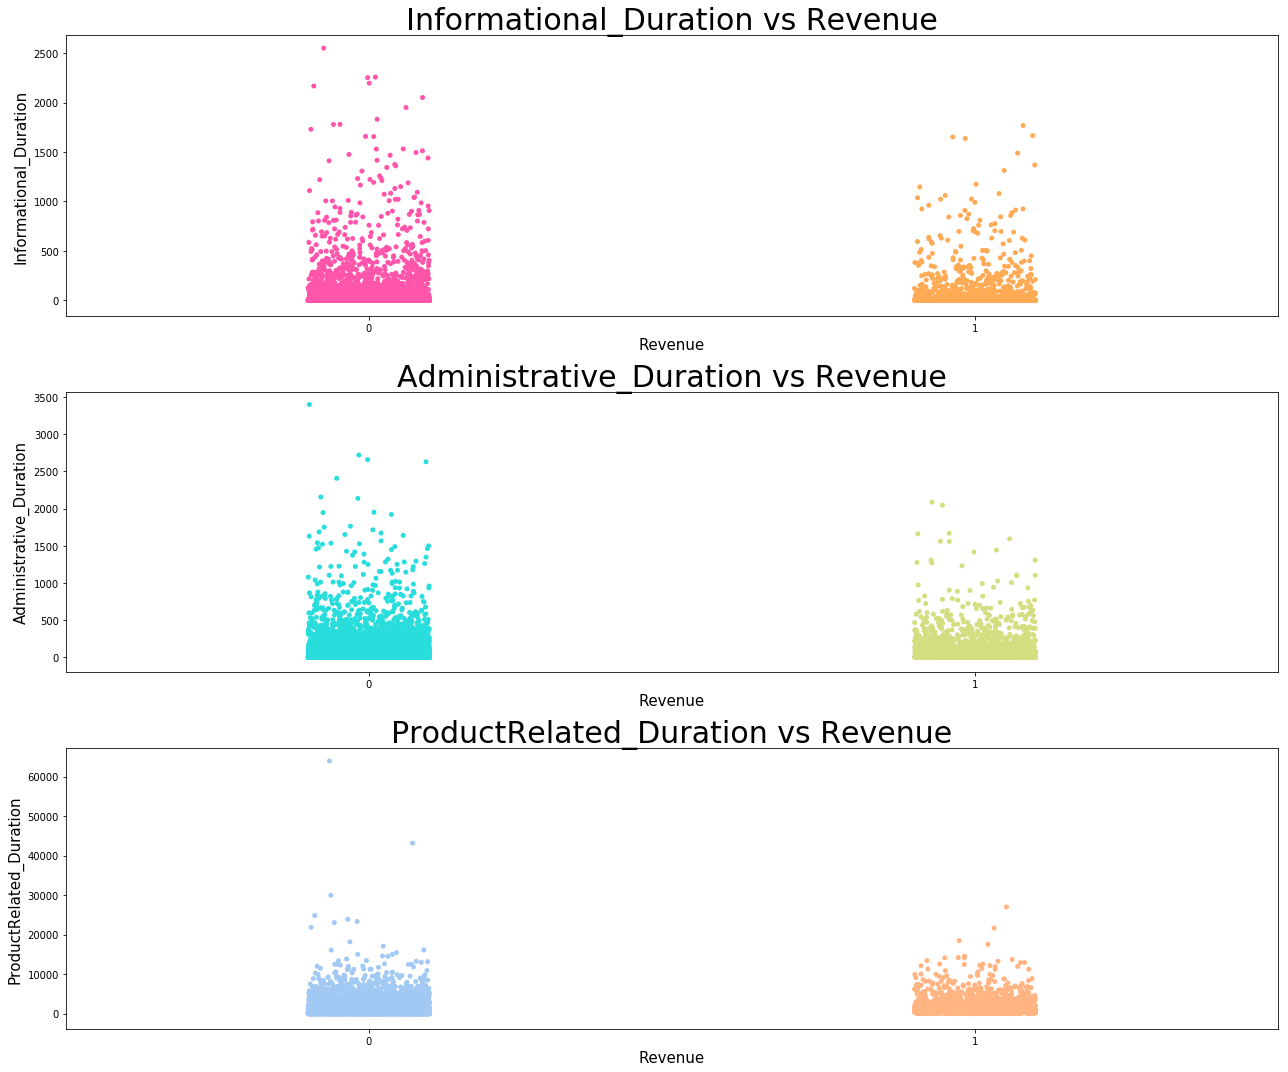

In [21]:
# Informational_Duration, Administrative_Duration, product related duration vs revenue

plt.rcParams['figure.figsize'] = (18, 15)

labels = ['Informational_Duration', 'Administrative_Duration', 'ProductRelated_Duration']
palettes = ['spring', 'rainbow', 'pastel']
for index, label in enumerate(labels):
    plt.subplot(3, 1, index+1)
    sns.stripplot(data['Revenue'], data[label], palette = palettes[index])
    title = label + ' vs Revenue' 
    plt.title(title, fontsize = 30)
    plt.ylabel(label, fontsize = 15)
    plt.xlabel('Revenue', fontsize = 15)
    plt.tight_layout()
    plt.savefig(label)


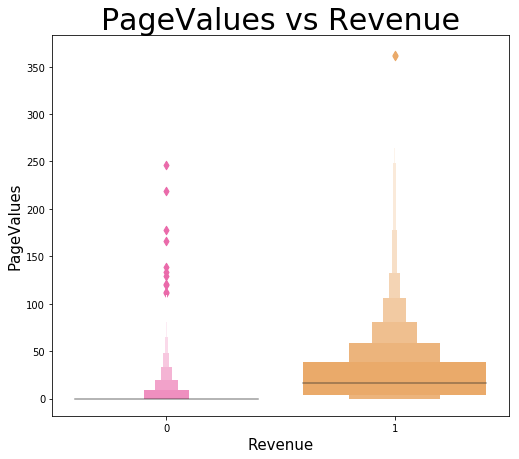

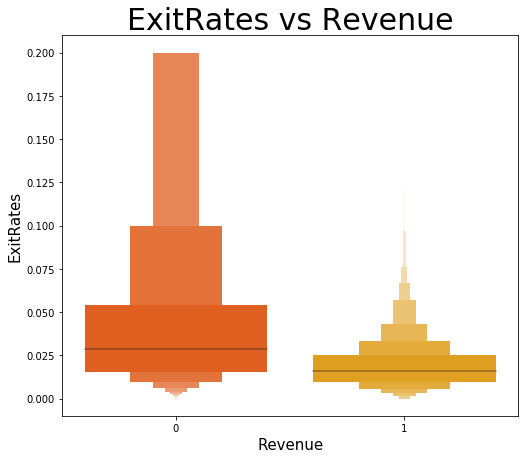

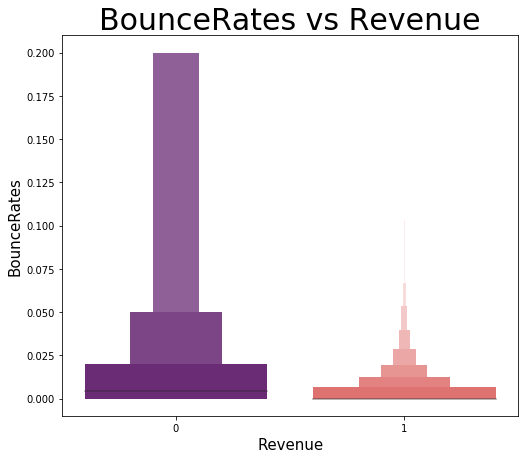

In [22]:
plt.rcParams['figure.figsize'] = (18, 7)
labels = ['PageValues', 'ExitRates', 'BounceRates']
palettes = ['spring', 'autumn', 'magma']

for index, label in enumerate(labels):
    plt.subplot(1, 2, 1)
    sns.boxenplot(data['Revenue'], data[label], palette = palettes[index])
    title = label + ' vs Revenue' 
    plt.title(title, fontsize = 30)
    plt.ylabel(label, fontsize = 15)
    plt.xlabel('Revenue', fontsize = 15)
    plt.show()


In [0]:
# Converting non-numeric values to numbers

# Assigning numbers to Months
temp_data = data
month_map={'Feb':2,'Mar':3,'May':5,'June':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12}
temp_data['Month']=temp_data['Month'].map(month_map)

#Assigning numbers to Visitor Type
vistor_map={'New_Visitor':0,'Returning_Visitor':1,'Other':2}
temp_data['VisitorType']=temp_data['VisitorType'].map(vistor_map)
temp_data['Weekend'] = temp_data['Weekend'].astype(int)

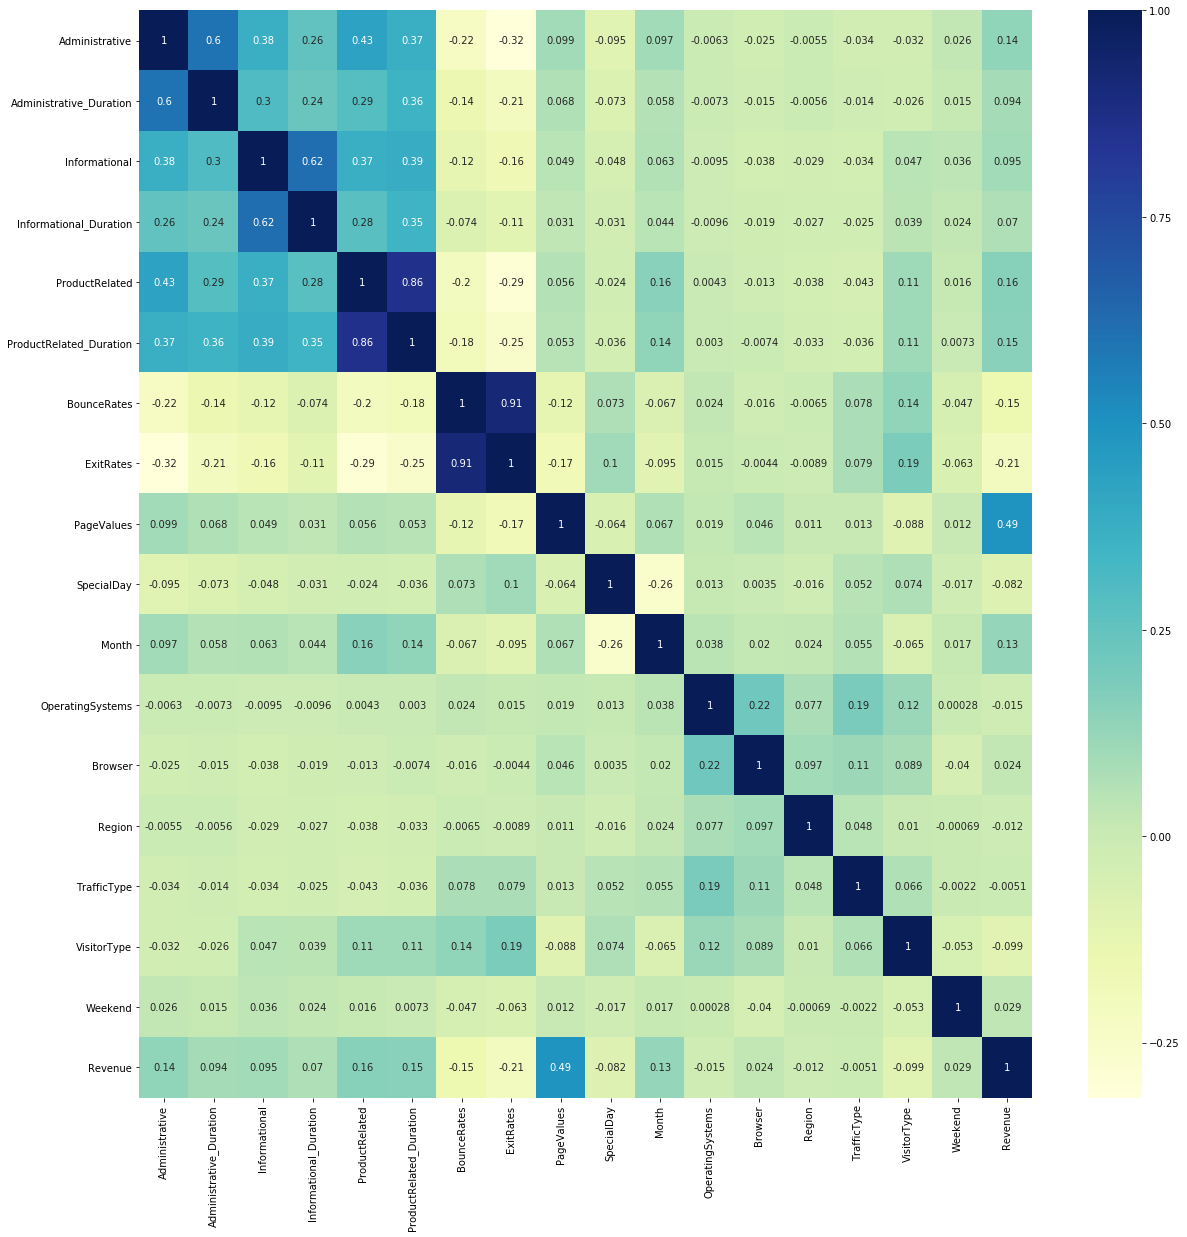

In [24]:
# Correlations between features.

correlations=temp_data.corr()
correlations

plt.figure(figsize=(20,20))
sns.heatmap(correlations,xticklabels=correlations.columns,yticklabels=correlations.columns,annot=True, cmap="YlGnBu")

In [25]:
temp_data.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,2,1,1,1,1,1,0,0
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,2,2,2,1,2,1,0,0
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,2,4,1,9,3,1,0,0
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,2,3,2,2,4,1,0,0
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,2,3,3,1,4,1,1,0


## Modeling

### Helper Methods

In [0]:
# Method to split data into for Training and Testing.

def split_data(myData, testSize, className = 'Revenue'):
  
  x = myData.drop([className], axis=1)
  y = myData[className]
  
  return train_test_split(x, y, test_size=testSize, random_state=12)

In [0]:
# Smote - oversampling
def smotify(x_train, y_train):
  smt = SMOTE()
  return smt.fit_sample(x_train, y_train)

In [0]:
# Method to evaluate the model and create a classification report and a confusion matrix

def evaluate_model(y_test, y_pred):

  acc = accuracy_score(y_test, y_pred)
  print('Accuracy : ', acc)

  # classification report
  cr = classification_report(y_test, y_pred)
  print('Classification Report :')
  print(cr)
  
  # confusion matrix
  cm = confusion_matrix(y_test, y_pred)
  print('Confusion Matrix :')
  
  plt.rcParams['figure.figsize'] = (6, 6)
  sns.heatmap(cm ,annot = True)

## 1. Naive Bayes

Accuracy :  0.8056231413895647
Classification Report :
              precision    recall  f1-score   support

           0       0.94      0.82      0.88      3114
           1       0.43      0.73      0.54       585

    accuracy                           0.81      3699
   macro avg       0.69      0.78      0.71      3699
weighted avg       0.86      0.81      0.82      3699

Confusion Matrix :


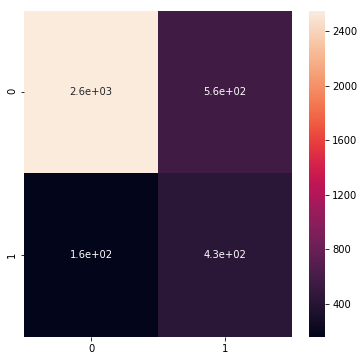

In [29]:
# A basic Gaussian Naive Bayes model

models = []

gnb = GaussianNB()

x_train, x_test, y_train, y_test = split_data(temp_data, 0.3)

x, y = smotify(x_train, y_train)

y_pred = gnb.fit(x, y).predict(x_test)

models.append({'model' : gnb, 'label': 'Naive Bayes', 'x_test': x_test, 'y_test': y_test})

evaluate_model(y_test, y_pred)

## 2. Random Forest Search

In [30]:
# Split data

#x_train, x_test, y_train, y_test = split_data(temp_data, 0.3)

# checking the shapes

print("Shape of x_train :", x_train.shape)
print("Shape of y_train :", y_train.shape)
print("Shape of x_test :", x_test.shape)
print("Shape of y_test :", y_test.shape)

Shape of x_train : (8631, 17)
Shape of y_train : (8631,)
Shape of x_test : (3699, 17)
Shape of y_test : (3699,)


Accuracy :  0.8948364422816978
Classification Report :
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      3114
           1       0.68      0.63      0.65       585

    accuracy                           0.89      3699
   macro avg       0.81      0.79      0.80      3699
weighted avg       0.89      0.89      0.89      3699

Confusion Matrix :


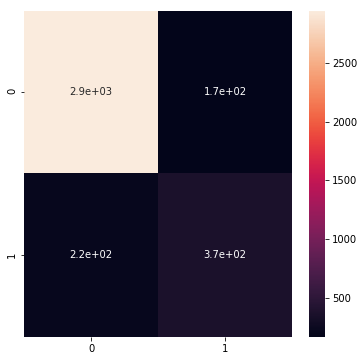

In [31]:
# Modeling a Random Forest Classifier

model = RandomForestClassifier()

x, y = smotify(x_train, y_train)

model.fit(x, y)

y_pred = model.predict(x_test)

# models.append({'model' : model, 'label': 'Random Forest Search', 'x_test': x_test, 'y_test': y_test})

evaluate_model(y_test, y_pred)


Optimal number of features: 10
Selected features: ['Administrative', 'Administrative_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues', 'Month', 'Region', 'TrafficType']


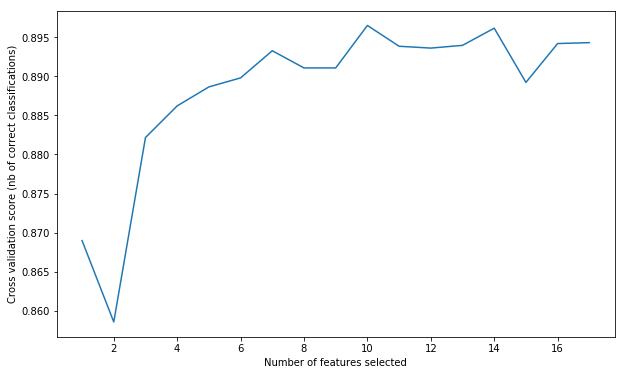

In [32]:
from sklearn.feature_selection import RFECV
# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring is proportional to the number of correct classifications
x_train_rfe = x_train
y_train_rfe = y_train
rfecv = RFECV(estimator=RandomForestClassifier(), step=1, cv=10, scoring='accuracy')
rfecv.fit(x_train_rfe, y_train_rfe)

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(x_train_rfe.columns[rfecv.support_]))


# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Accuracy :  0.8937550689375506
Classification Report :
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      3114
           1       0.66      0.67      0.67       585

    accuracy                           0.89      3699
   macro avg       0.80      0.80      0.80      3699
weighted avg       0.89      0.89      0.89      3699

Confusion Matrix :


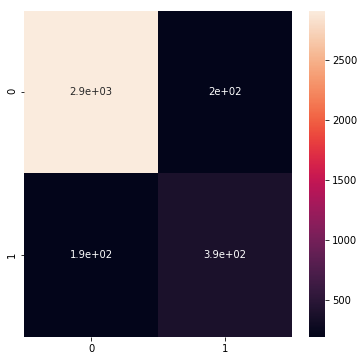

In [33]:
selected_features = list(x_train.columns[rfecv.support_])
x_train_rfe = x_train[selected_features]
x_test_rfe = x_test[selected_features]

model_rfe = RandomForestClassifier()

x, y = smotify(x_train_rfe, y_train)
model_rfe.fit(x, y)

y_pred = model_rfe.predict(x_test_rfe)

models.append({'model' : model_rfe, 'label': 'Random Forest Search', 'x_test': x_test_rfe, 'y_test': y_test})

evaluate_model(y_test, y_pred)

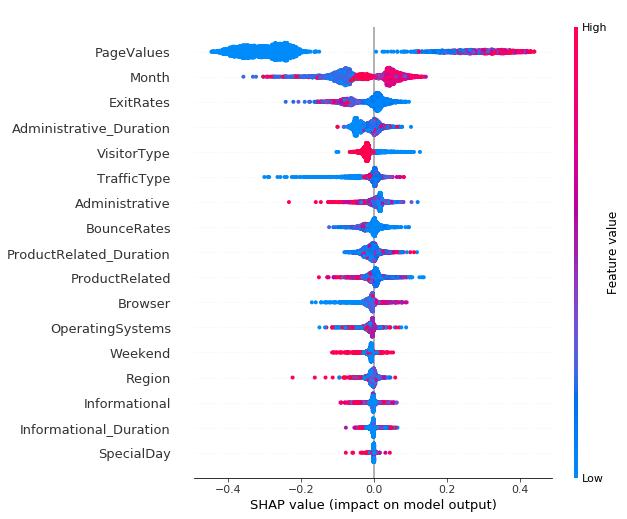

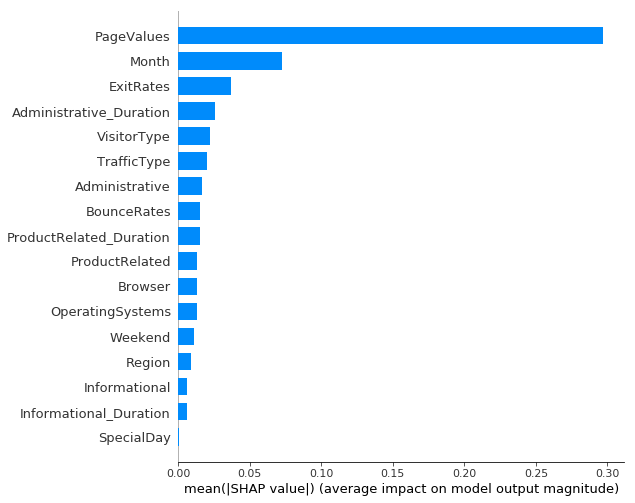

In [34]:
# let's take a look at the shap values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_test)
shap.summary_plot(shap_values[1], x_test)
shap.summary_plot(shap_values[1], x_test, plot_type='bar')

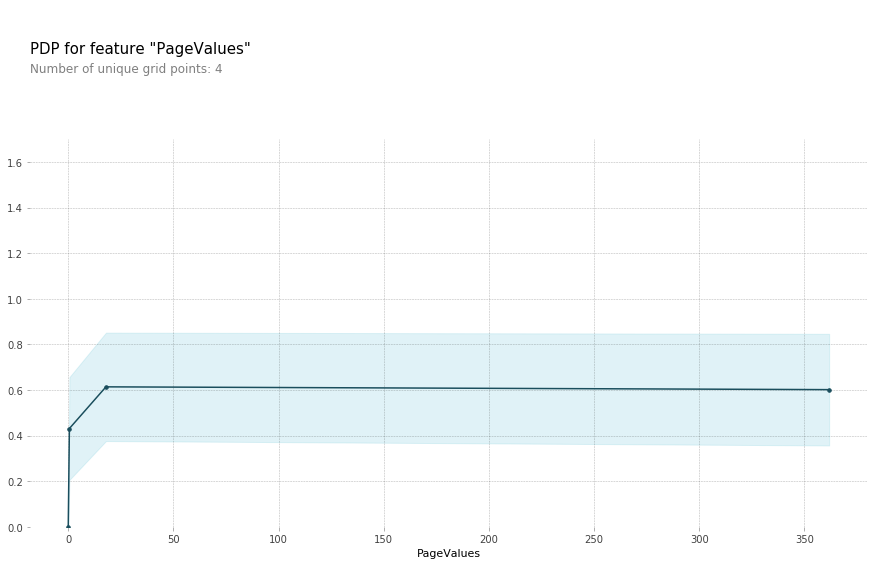

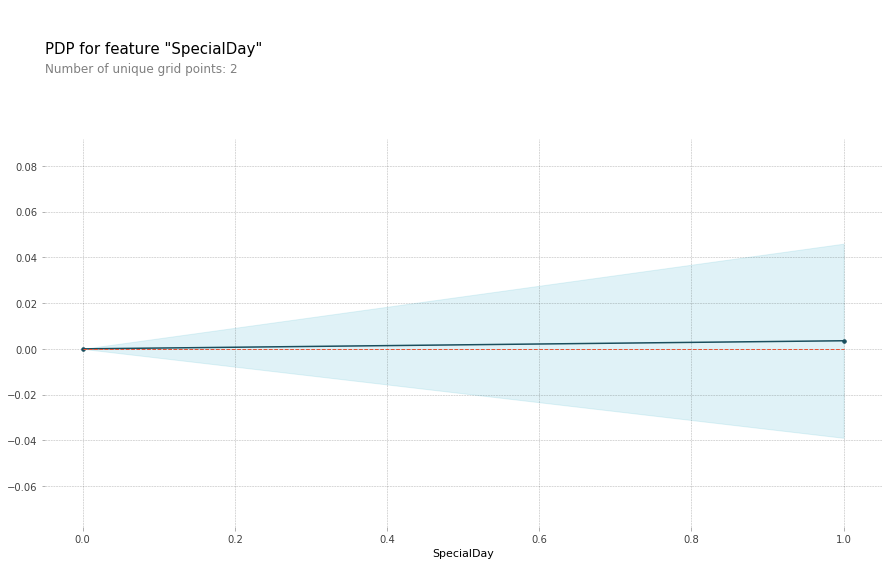

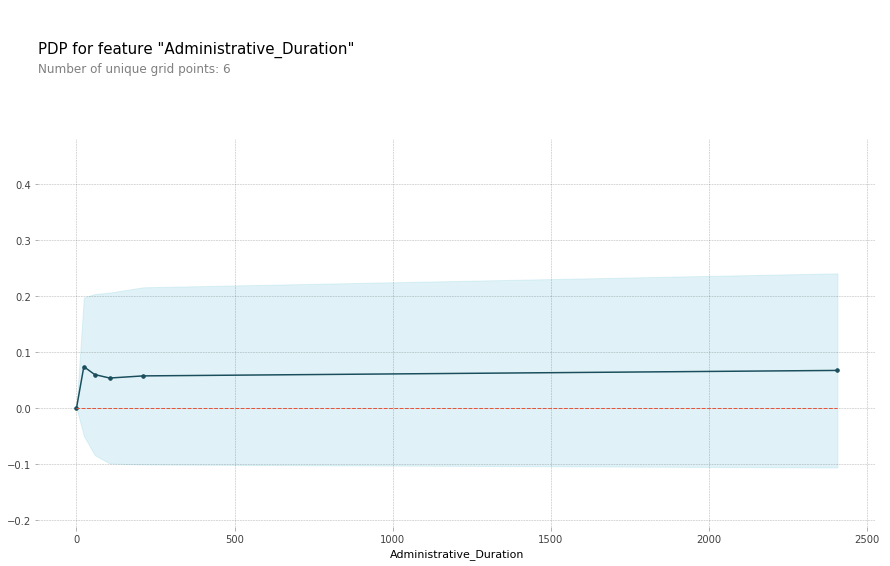

In [35]:
# plotting the partial dependence plot for adminisrative duration

# importing pdp
from pdpbox import pdp, info_plots

base_features = x_test.columns.values.tolist()

feat_name = 'PageValues'
pdp_dist = pdp.pdp_isolate(model=model, dataset=x_test, model_features = base_features, feature = feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

feat_name = 'SpecialDay'
pdp_dist = pdp.pdp_isolate(model=model, dataset=x_test, model_features = base_features, feature = feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

feat_name = 'Administrative_Duration'
pdp_dist = pdp.pdp_isolate(model=model, dataset=x_test, model_features = base_features, feature = feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

## 3. Logistic Regression

Accuracy :  0.8832116788321168
Classification Report :
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      3114
           1       0.76      0.38      0.51       585

    accuracy                           0.88      3699
   macro avg       0.83      0.68      0.72      3699
weighted avg       0.87      0.88      0.87      3699

Confusion Matrix :


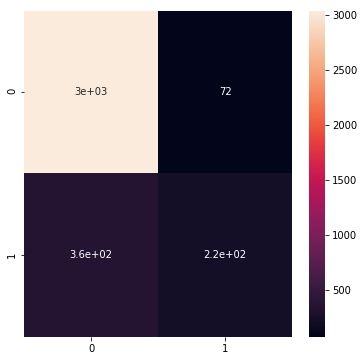

In [36]:
# A Logistic regression model 

#x_train, x_test, y_train, y_test = split_data(temp_data, 0.3)

model = LogisticRegression()

x, y = smotify(x_train, y_train)

model.fit(x_train,y_train)

y_pred = model.predict(x_test)

# models.append({'model' : model, 'label': 'Logistic Regression', 'x_test': x_test, 'y_test': y_test})

evaluate_model(y_test, y_pred)


Optimal number of features: 9
Selected features: ['Informational', 'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month', 'OperatingSystems', 'VisitorType', 'Weekend']


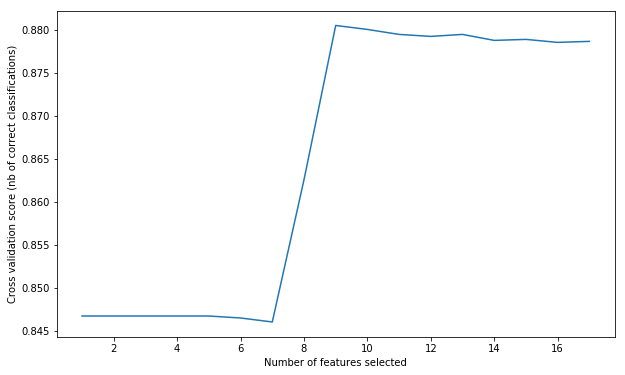

In [37]:
from sklearn.feature_selection import RFECV
# Create the RFE object and compute a cross-validated score.
# The "accuracy" scoring is proportional to the number of correct classifications

x_train_rfe = x_train
y_train_rfe = y_train

rfecv = RFECV(estimator=LogisticRegression(), step=1, cv=10, scoring='accuracy')
rfecv.fit(x_train_rfe, y_train_rfe)

print("Optimal number of features: %d" % rfecv.n_features_)
print('Selected features: %s' % list(x_train_rfe.columns[rfecv.support_]))


# Plot number of features VS. cross-validation scores
plt.figure(figsize=(10,6))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

Accuracy :  0.8778048121113815
Classification Report :
              precision    recall  f1-score   support

           0       0.95      0.90      0.93      3114
           1       0.59      0.75      0.66       585

    accuracy                           0.88      3699
   macro avg       0.77      0.82      0.79      3699
weighted avg       0.89      0.88      0.88      3699

Confusion Matrix :


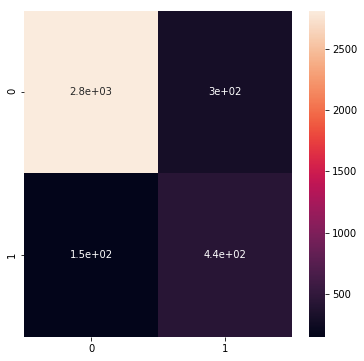

In [38]:
selected_features = list(x_train.columns[rfecv.support_])
x_train_rfe = x_train[selected_features]
x_test_rfe = x_test[selected_features]

model_rfe = LogisticRegression()

x, y = smotify(x_train_rfe,y_train)

model_rfe.fit(x, y)

y_pred = model_rfe.predict(x_test_rfe)

models.append({'model' : model_rfe, 'label': 'Logistic Regression', 'x_test': x_test_rfe, 'y_test': y_test})

evaluate_model(y_test, y_pred)

## 4. Support Vector Machine

Accuracy :  0.8094079480940795
Classification Report :
              precision    recall  f1-score   support

           0       0.95      0.82      0.88      3114
           1       0.44      0.75      0.56       585

    accuracy                           0.81      3699
   macro avg       0.69      0.79      0.72      3699
weighted avg       0.87      0.81      0.83      3699

Confusion Matrix :


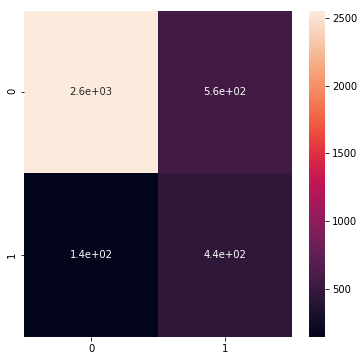

In [39]:
# An SVM model

#x_train, x_test, y_train, y_test = split_data(temp_data, 0.3)

svc = SVC(C=3,probability=True, gamma='scale')

x, y = smotify(x_train, y_train)

svc.fit(x, y) 

y_pred=svc.predict(x_test)

models.append({'model' : svc, 'label': 'Support Vector Machine', 'x_test': x_test, 'y_test': y_test})

evaluate_model(y_test, y_pred)

## 5. Neural Network



In [40]:
# Split data

#x_train, x_test, y_train, y_test = split_data(temp_data, 0.3)

# checking the shapes

print("Shape of x_train :", x_train.shape)
print("Shape of y_train :", y_train.shape)
print("Shape of x_test :", x_test.shape)
print("Shape of y_test :", y_test.shape)

Shape of x_train : (8631, 17)
Shape of y_train : (8631,)
Shape of x_test : (3699, 17)
Shape of y_test : (3699,)


In [41]:
# Construct the Neural Network

model = keras.Sequential([
    keras.layers.Dense(60, input_shape=(x_train.shape[1],), activation=tf.nn.relu),
    keras.layers.Dense(units=1, activation=tf.nn.sigmoid)
])


W0807 07:04:03.126642 140299192842112 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [42]:
# model compilation - adding loss function, optimizer and a method for metrics

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

model.summary()

W0807 07:04:03.256798 140299192842112 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 60)                1080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 61        
Total params: 1,141
Trainable params: 1,141
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Fit the model to the data 

x, y = smotify(x_train, y_train)

stats = model.fit(x, y, epochs=80, validation_data=(x_test, y_test), verbose=False)

Accuracy :  0.8918626655852934
Classification Report :
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      3114
           1       0.66      0.66      0.66       585

    accuracy                           0.89      3699
   macro avg       0.80      0.80      0.80      3699
weighted avg       0.89      0.89      0.89      3699

Confusion Matrix :
Confusion Matrix :
3699/3699 [==============================] - 0s 25us/sample - loss: 0.3441 - acc: 0.8919


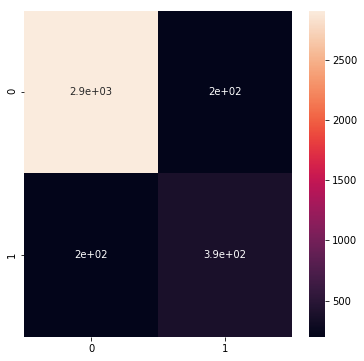

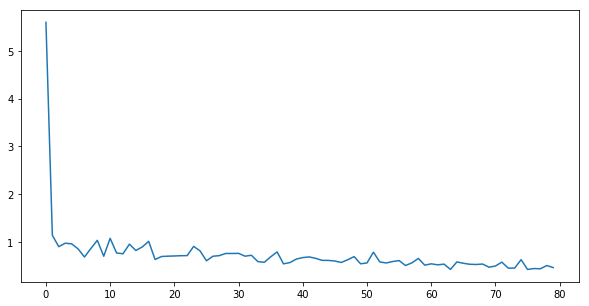

Training accuracy: 0.88749856
Testing accuracy: 0.8918627


In [44]:
models.append({'model' : model, 'label': 'Neural Network', 'x_test': x_test, 'y_test': y_test})
y_pred = model.predict(x_test)
evaluate_model(y_test, y_pred.round())
print('Confusion Matrix :')

train_acc=model.evaluate(x_train, y_train, batch_size=1000)[1]
test_acc=model.evaluate(x_test, y_test, batch_size=1000)[1]
test_loss, test_accuracy = model.evaluate(x_test, y_test)
losses= stats.history['loss']
plt.figure(figsize=(10,5))
plt.plot(range(len(losses)), losses)
plt.show()
print("Training accuracy: %s" % train_acc)
print("Testing accuracy: %s" % test_acc)

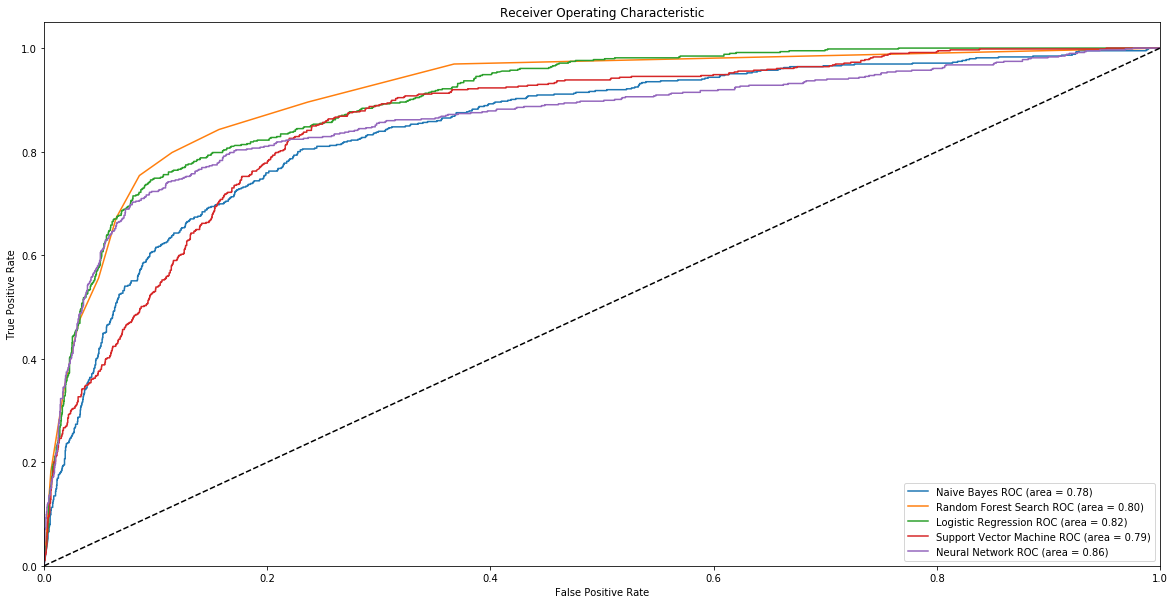

In [45]:
# plotting ROC curves


plt.figure(figsize=(20,10))
for m in models:
  model = m['model']
  x_test = m['x_test']
  y_test = m['y_test']
  pred_proba = model.predict_proba(x_test)
  if m['label'] != 'Neural Network':
    pred_proba = pred_proba[:,1]
  # Compute False postive rate, and True positive rate
  fpr, tpr, thresholds = roc_curve(y_test, pred_proba)
  # Calculate Area under the curve to display on the plot
  auc = roc_auc_score(y_test,model.predict(x_test))
  # Now, plot the computed values
  plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))

plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

From the above plot of ROC curves for the explored models, we can observe that Neural Network has the largest area under the curve. The dotted line denotes a model that makes predictions at random. Hence, we can safely say that all our models perform better than a random classifier.

[('Naive Bayes', 0.8056231413895647), ('Support Vector Machine', 0.8094079480940795), ('Logistic Regression', 0.8778048121113815), ('Neural Network', 0.8918627), ('Random Forest Search', 0.8937550689375506)]


(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

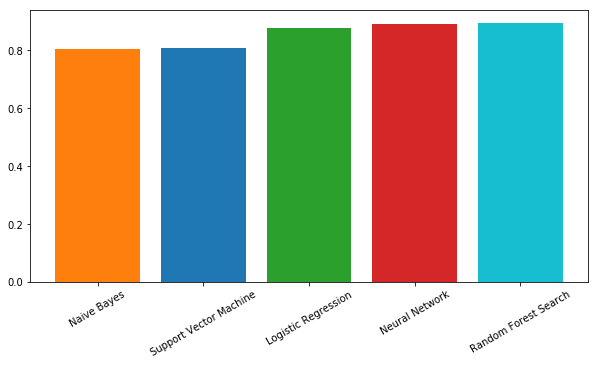

In [46]:
plt.figure(figsize=(10, 5))
accuracy_dict = {}
for m in models:
  model = m['model']
  x_test = m['x_test']
  y_test = m['y_test']
  
  if m['label'] != 'Neural Network':
    y_pred = model.predict(x_test)
    acc_score = accuracy_score(y_test, y_pred)
    accuracy_dict[m['label']] = acc_score
  else:
    acc_score = test_acc
    accuracy_dict[m['label']] = acc_score
  
sorted_x = sorted(accuracy_dict.items(), key=lambda kv: kv[1])
print(sorted_x)
import collections
sorted_dict = collections.OrderedDict(sorted_x)
# plt.bar(m['label'], acc_score)
plt.bar(range(len(sorted_dict)), list(sorted_dict.values()), align='center', color=['tab:orange', 'tab:blue','tab:green','tab:red', 'tab:cyan'])
plt.xticks(range(len(sorted_dict)), list(sorted_dict.keys()))
plt.xticks(rotation=30)